In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow version: 2.8.0
GPU detected: []


 - [x] get the file
 - [x] read the rows
 - [x] tpkenize the snetences
 - [ ] join date and source to sentence
 - [x] find location (lowercase), and fatalities of not zero (number in word too)
 - [x] skip the sentences that:
    - [ ] no sentence ... Auto?
    - [ ] location not in sentence
    - [ ] 0 fatalities
 - [x] make a new csv with tagged entities
 - [x] input to this model 
 - [x] test accuracy 
 - [x] cry: reason for high accuracy, nearly everything is O
 - [x] figure how to measure accuracy of only specific tags
 - [x] test accuracy again
 - [x] Cry: on below 50% accuracy, monkeys can do better ... okay 56%
 - [ ] figure out how to get location out of on normal sentence
 - [ ] label it as test set
 - [ ] test accuracy again
 - [ ] Cry: on below 50% accuracy, monkeys can do better
 - [ ] 
 - [ ] Ask on Piazza if accuracy below 50 okay, and this is what I tried, what could be done better
 - [ ] Spacy

In [ ]:
!pip3 install text2digits

In [ ]:
raw_data = pd.read_csv('task_1_information_extraction_train.csv')
raw_data = raw_data.fillna(method='ffill')
raw_data.head(2)

,NOTES,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION
0,Three people were killed while 27 others injur...,29-August-2012,Statesman (Pakistan),3,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Pakistan),3,Civilians (Pakistan),7,37,Jacobabad
1,Government security forces opened fire at a pr...,03-May-2014,Undisclosed Source,0,Violence against civilians,Attack,Military Forces of Somalia (2012-2017),1,Civilians (Somalia),7,17,Baidoa


In [ ]:
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

tokens = tokenizer("This, is a sentence")
for token in tokens:
    print(token.text)

This
,
is
a
sentence


In [ ]:
#tokenization
import spacy
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

'foo'

In [ ]:
# for d in data[:3]:
#     print(d)

# df = pd.DataFrame({'c1': [10, 11, 12], 'c2': [100, 110, 120]})
# df = df.reset_index()  # make sure indexes pair with number of rows
# for index, row in df.iterrows():
#     print(row['c1'], row['c2'])

# ['Sentence #', 'Word', 'POS', 'Tag']

from text2digits import text2digits
t2d = text2digits.Text2Digits()


sentence_nos = []
words = []
poss = []
tags = []

no_sen_nos = []

for index, row in raw_data.head(20000).iterrows():
    sentence = row['NOTES'].strip()

    if sentence:
        tokens = tokenizer(sentence)
        for token in tokens:
            word = token.text
            if word not in ['.', ',', ')', '(']:
            
                sentence_nos.append(index)
                words.append(word)
                tag = 'O'
                if word.lower() == row['LOCATION'].lower():
                    tag = "LOCATION"
                if t2d.convert(word).isdigit() and int(t2d.convert(word)) == row['FATALITIES']:
                    tag = "FATALITIES"
                tags.append(tag)
                poss.append("_")
    else:
        no_sen_nos.append(index)


data = pd.DataFrame({'Sentence #': sentence_nos, 'Word': words, 'POS': poss, 'Tag': tags})

print(len(no_sen_nos))

0


In [ ]:
data.to_csv('cleaned_data.csv', encoding='utf-8')

In [ ]:
data.head(100)

,Sentence #,Word,POS,Tag
0,0,Three,_,FATALITIES
1,0,people,_,O
2,0,were,_,O
3,0,killed,_,O
4,0,while,_,O
...,...,...,...,...
95,3,government,_,O
96,3,for,_,O
97,3,the,_,O
98,3,first,_,O


In [ ]:
# data = pd.read_csv('ner_dataset.csv', encoding='latin1')
# data = data.fillna(method='ffill')
# data.head(20)

In [ ]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [ ]:
print("unique words; ",data["Word"].nunique())
print("unique tags; ",data["Tag"].nunique())

unique words;  32716
unique tags;  3


In [ ]:
#creating dataset for unique words, tags
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))
tags

['LOCATION', 'O', 'FATALITIES']

In [ ]:
np.shape(words)

(32717,)

In [ ]:
num_words = len(words)
num_tags = len(tags)
num_tags

3

In [ ]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_fun)
        self.sentences = [i for i in self.grouped]
    
    

In [ ]:
getter = Sentence_getter(data)

In [ ]:
sentences = getter.sentences

In [ ]:
sentences[0]

[('Three', '_', 'FATALITIES'),
 ('people', '_', 'O'),
 ('were', '_', 'O'),
 ('killed', '_', 'O'),
 ('while', '_', 'O'),
 ('27', '_', 'O'),
 ('others', '_', 'O'),
 ('injured', '_', 'O'),
 ('when', '_', 'O'),
 ('a', '_', 'O'),
 ('Peshawar', '_', 'O'),
 ('-', '_', 'O'),
 ('bound', '_', 'O'),
 ('train', '_', 'O'),
 ('hit', '_', 'O'),
 ('a', '_', 'O'),
 ('bomb', '_', 'O'),
 ('planted', '_', 'O'),
 ('by', '_', 'O'),
 ('unidentified', '_', 'O'),
 ('militants', '_', 'O'),
 ('on', '_', 'O'),
 ('railway', '_', 'O'),
 ('tracks', '_', 'O'),
 ('in', '_', 'O'),
 ('Tul', '_', 'O'),
 ('town', '_', 'O'),
 ('in', '_', 'O'),
 ('Jacobabad', '_', 'LOCATION'),
 ('district', '_', 'O'),
 ('in', '_', 'O'),
 ('Sindh', '_', 'O')]

In [ ]:
# Creating vocabulary
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [ ]:
tag2idx

{'FATALITIES': 2, 'LOCATION': 0, 'O': 1}

**Hist plot of len of sentences**

[]

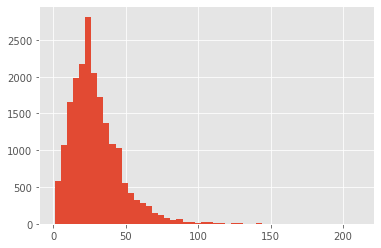

In [ ]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.plot()

Lets take 50 as maxlen to be on safer side

Padding inputs to maxlen

Creating INPUTS AND OUTPUTS

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 100

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])


Converting output labes to categorical ( ONE_HOT )

In [ ]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
y[0]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

Now train-test splitting

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=1 )

Building and compiling a BiLSTM

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_ta=gs, activation='softmax'))(model)

model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          3271700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 3)           603       
 ibuted)                                                         
                                                             

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

TRAINING MODEL with per-epoch visualizations using CALLBACKS

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras


In [ ]:
type(y_train)

list

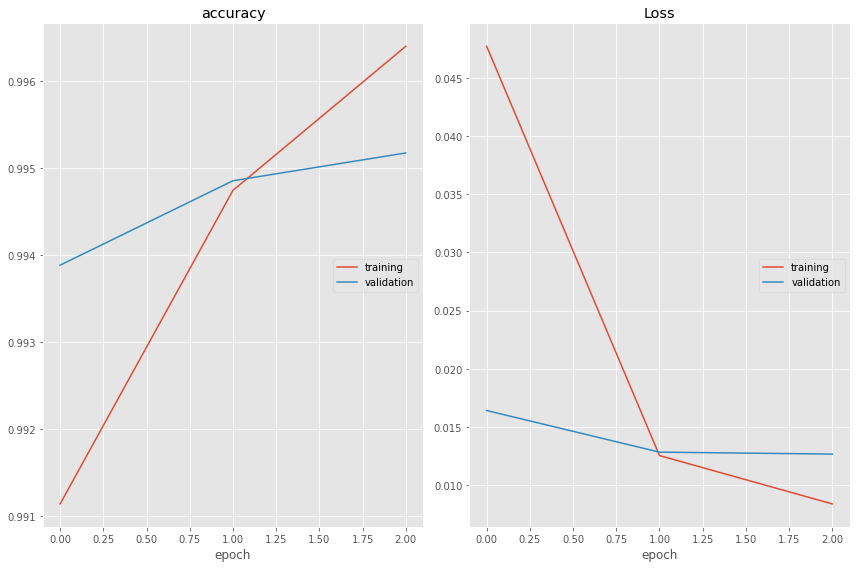

accuracy
	training         	 (min:    0.991, max:    0.996, cur:    0.996)
	validation       	 (min:    0.994, max:    0.995, cur:    0.995)
Loss
	training         	 (min:    0.008, max:    0.048, cur:    0.008)
	validation       	 (min:    0.013, max:    0.016, cur:    0.013)
450/450 [==============================] - 164s 364ms/step - loss: 0.0084 - accuracy: 0.9964 - val_loss: 0.0127 - val_accuracy: 0.9952


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
model.evaluate(x_test, np.array(y_test))

63/63 [==============================] - 4s 68ms/step - loss: 0.0142 - accuracy: 0.9945


[0.014166239649057388, 0.9944599866867065]

In [ ]:
x_test[0]

array([10740, 21580,  5273, 25343,  3925, 20504, 20501, 21921,  2169,
       11203, 18765, 12762, 31234,  9287, 25481, 31882,  1981, 29511,
       10623, 12762, 29871, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716, 32716,
       32716], dtype=int32)

In [ ]:
len(word2idx)

32717

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)



for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))

Word           True 	Pred

------------------------------
Armed          O	O
herders        O	O
shot           O	O
and            O	O
killed         O	O
a              O	O
farmer         O	O
as             O	O
she            O	O
was            O	O
attempting     O	O
to             O	O
chase          O	O
away           O	O
the            O	O
herders        O	O
camels         O	O
from           O	O
her            O	O
farmland       O	O
in             O	O
Hawa           O	O
Nureldaim      O	O
near           O	O
Tawila         O	LOCATION
locality       O	O
Two            O	O
other          O	O
people         O	O
on             O	O
the            O	O
farm           O	O
were           O	O
abducted       O	O
and            O	O
livestock      O	O
taken          O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarmac         O	O
tarm

In [ ]:
non_o_counts = 0
non_o_counts_correct = 0
for i in range(x_test.shape[0]):
    p = model.predict(np.array([x_test[i]]))
    # print(np.shape(p))
    # print(p)
    p = np.argmax(p, axis=-1)

    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    for (w, t, pred) in zip(x_test[i], y_true, p[0]):
        if not tags[t] == "O":
            non_o_counts += 1
            if tags[t] == tags[pred]:
                non_o_counts_correct += 1

In [ ]:
print(non_o_counts, non_o_counts_correct)

1551 879


In [ ]:
non_o_counts_correct / non_o_counts

0.5667311411992263

In [ ]:
model.save('loc_and_fata')

INFO:tensorflow:Assets written to: loc_and_fata/assets


In [ ]:
loaded = tf.keras.models.load_model("loc_and_fata")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
